<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/tim-branch/tim-playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import sys

!{sys.executable} -m pip install pydicom -q

In [115]:
from google.colab import drive
drive.mount('/content/drive')

In [116]:
from IPython.display import clear_output

path = '/content/drive/MyDrive/capstone/assets/stage_2_train_images.zip'

!unzip {path}
clear_output(wait=True)

In [117]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam
import torch
import torchvision
import pydicom as dicom

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os

In [118]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
    if indices:
      self.img_labels = pd.read_csv(annotations_file).iloc[indices]
    else:
      self.img_labels = pd.read_csv(annotations_file)

    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = ''.join([os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]), '.dcm'])
    
    image = dicom.dcmread(os.path.join(self.img_dir, img_path))
    image = image.pixel_array

    label = self.img_labels.iloc[idx, -1]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

  def get_classes(self):
    return self.img_labels.iloc[:, -1].unique()

  classes = property(get_classes)

In [119]:
annotations_file = '/content/drive/MyDrive/capstone/assets/stage_2_train_labels.csv.zip'
img_dir = '/content'

label_df = pd.read_csv(annotations_file)

X_train, X_test = train_test_split(label_df, test_size=.7, stratify=label_df.Target, random_state=99)
X_train, X_val, = train_test_split(X_train, test_size=.6, stratify=X_train.Target, random_state=99)
X_train, X_val, X_test = X_train.index.tolist(), X_val.index.tolist(), (X_test
                                                                        .groupby('Target')
                                                                        .apply(lambda grp: grp.sample(2000, random_state=99))
                                                                        .droplevel(0)
                                                                        .index
                                                                        .tolist())

len(X_train), len(X_val),  len(X_test)

(3627, 5441, 4000)

In [120]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.Normalize(0.5547, 0.1781),
    torchvision.transforms.RandomHorizontalFlip(.1),
    torchvision.transforms.RandomRotation(degrees=(-7, 7))
])

eval_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.Normalize(0.5547, 0.1781),
])

train_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_train, transform=train_transform)
val_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_val, transform=eval_transform)
test_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_test, transform=eval_transform)

In [121]:
class LeNet(torch.nn.Module):
  def __init__(self, num_channels, classes):
    super(LeNet, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=num_channels, out_channels=20, kernel_size=20)
    self.relu1 = torch.nn.ReLU()
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = torch.nn.ReLU()
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    
    self.fc1 = torch.nn.Linear(in_features=162450, out_features=500)
    self.relu3 = torch.nn.ReLU()
    
    self.fc2 = torch.nn.Linear(in_features=500, out_features=classes)
    self.logSoftmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):

    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)

    x = self.fc2(x)
    output = self.logSoftmax(x)

    return output

init_learning_rate = 1e-3
batch_size = 32
epochs = 5

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size)

print('training steps per epoch:', len(train_data_loader.dataset)//batch_size)
print('validation steps per epoch:', len(val_data_loader.dataset)//batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet(num_channels=1, classes=len(train_data_loader.dataset.classes)).to(device)

opt = Adam(model.parameters(), lr=init_learning_rate)
loss_fn = torch.nn.NLLLoss()

training steps per epoch: 113
validation steps per epoch: 170


In [122]:
for e in range(epochs):
  model.train()

  total_training_loss = 0
  total_val_loss = 0

  train_correct = 0
  val_correct = 0

  for x, y in train_data_loader:
    x, y = x.to(device), y.to(device)

    pred = model(x)
    loss = loss_fn(pred, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    total_training_loss += loss
    train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  with torch.no_grad():
    model.eval()

    for (x, y) in val_data_loader:
      (x, y) = (x.to(device), y.to(device))
      pred = model(x)
      total_val_loss += loss_fn(pred, y)
      val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  print('Epoch {} completed - train loss: {:.4f} train correct pred: {} val loss {:4f} val correct pred: {}'.format(
      e+1, total_training_loss, train_correct, total_val_loss, val_correct
  ))

Epoch 1 completed - train loss: 93.5480 train correct pred: 2520.0 val loss 87.052376 val correct pred: 4069.0
Epoch 2 completed - train loss: 57.7241 train correct pred: 2740.0 val loss 85.008011 val correct pred: 4124.0
Epoch 3 completed - train loss: 54.8250 train correct pred: 2768.0 val loss 84.283340 val correct pred: 4191.0
Epoch 4 completed - train loss: 54.2107 train correct pred: 2794.0 val loss 84.787247 val correct pred: 4138.0
Epoch 5 completed - train loss: 50.8393 train correct pred: 2856.0 val loss 86.073448 val correct pred: 4112.0


In [123]:
test_data_loader =  DataLoader(test_dataset, batch_size=batch_size)

y_s = torch.Tensor().to(device)
preds = torch.Tensor(0, 2).to(device)

with torch.no_grad():
  model.eval()
  for i, (x, y) in enumerate(test_data_loader):
    x, y = x.to(device), y.to(device)

    pred = model(x)

    preds = torch.vstack((preds, pred))
    y_s = torch.cat((y_s, y), dim=0)

print('n true:', y_s.shape[0])
print('n predictions:', preds.shape[0])

n true: 4000
n predictions: 4000


precision:	0.7755
recall:		0.5975
f1:		0.6750



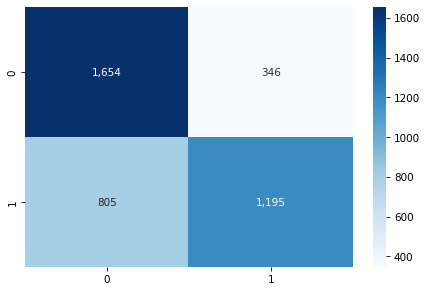

In [124]:
y_true = y_s.cpu().numpy()
y_pred = preds.cpu().numpy().argmax(axis=1)
y_proba = preds.cpu().numpy()[:, 1]

precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print('precision:\t{:.4f}'.format(precision))
print('recall:\t\t{:.4f}'.format(recall))
print('f1:\t\t{:.4f}'.format(f1))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
fig.show()

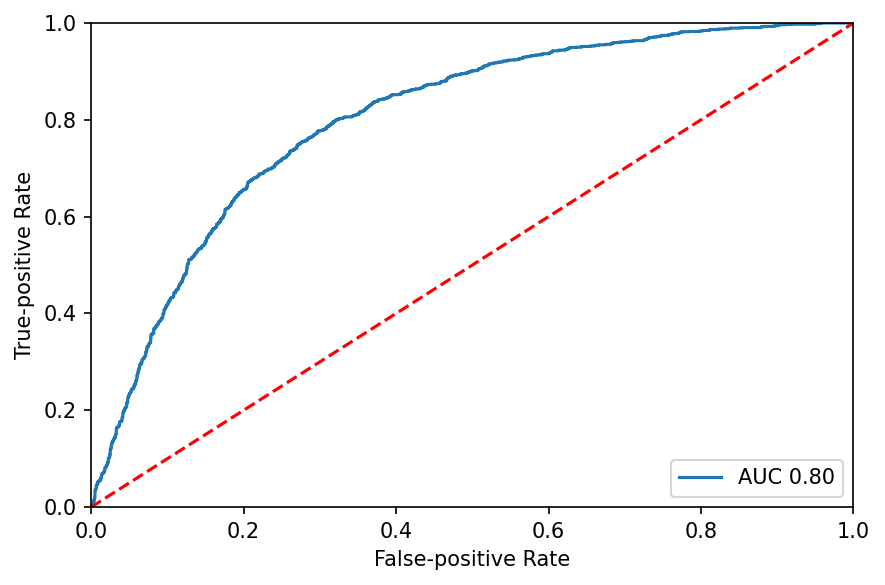

In [125]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

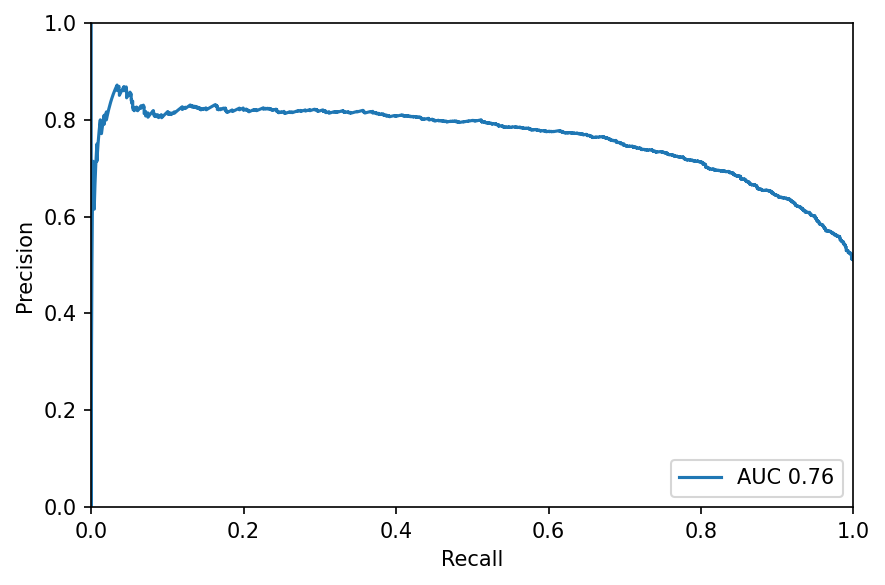

In [126]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()